In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import make_regression
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
import statsmodels.stats.api as sms
import numpy as np

/Users/jakekong/.pyenv/versions/3.6.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Replacing NAN values if exist & Catergorization if needed

In [2]:
df = pd.read_csv("train.csv")

In [3]:
del df["AnimalID"] # 종속변수 OutcomeType과 전혀 상관 없는 변수로 구분. 사용하지 않기로 결정.
del df["DateTime"] # OutcomeType 가 발생한 시간을 나타내는 것으로 종속변수에서 파생된 변수로 구분. 사용하지 않기로 결정.
del df["OutcomeSubtype"] #OutcomeType에 대한 부분적 설명을 해주는 변수로, 결국 종속변수에 의해 영향을 받은 변수. 사용하지 않기로 결정.

# OutcomeType has 5 outcomes
- Return_to_owner
- Euthanasia
- Adoption
- Transfer
- Died
- no NAN values

# Name grouped by 'With Name' & 'Without Name'
- Names do not have regular order to be given to animals, therefore we decided to group animals by with or without

In [4]:
df_for_name = pd.read_csv("train.csv")
df_for_name["Name"] = df_for_name["Name"].replace(np.nan, 'Unknown')

def Name(x):
    if x.find('Unknown') == 0: return "Without Name"
    return "With Name"

df["Name"] = df_for_name["Name"].apply(Name)



# AnimalType has 2 types
- Dogs
- Cats
- no NAN values

# SexuponOutcome has 4 types
- Neutered Male
- Spayed Female
- Intact Male
- Intact Female
- NAN values interpreted as "Unknown"

In [5]:
df_for_sex = pd.read_csv("train.csv")
df_for_sex["SexuponOutcome"] = df_for_sex["SexuponOutcome"].replace(np.nan, 'Unknown')

df["SexuponOutcome"] = df_for_sex["SexuponOutcome"]

# Additional SexuponOutcome categorization

In [6]:
def more_sex(x):
    if x.find("Neutered") >= 0: return 'neutered'
    elif x.find("Spayed") >= 0: return 'neutered'
    elif x.find("Intact") >= 0: return 'natural'
    else: return "Unknown"
    
df["SexuponOutcome"] = df_for_sex["SexuponOutcome"].apply(more_sex)

# AgeuponOutcome must be constructed into a varible that has types
- Replacing NAN values "Unknown"
- preprocessed into int values; age in year
- categorized into 7 divisions including the NAN values as "Unknown"

In [7]:
df_for_age = pd.read_csv('train.csv')
df_for_age["AgeuponOutcome"] = df_for_age["AgeuponOutcome"].replace(np.nan, "Unknown")

def age_by_year(x):
    if x == "Unknown": 
        return -1
    else:
        age = int(x.split(" ")[0])
        if x.find('year') >= 0: return age * 365
        if x.find('month') >= 0: return age * 30
        if x.find('week') >= 0: return age * 7
        if x.find('day') >= 0: return age 
        else: return 0

def class_age(x):
    if x == -1:
        return "Unknown"
    else:
        if x <= 1: return "1 year or less"
        if 1 < x <=3: return "1-3 years"
        if 3 < x <= 5: return "3-5 years"
        if 5 < x <= 10: return "5-10 years"
        if 10 < x <=15: return "10-15 years"
        else: return "15 years or more"
        
df_for_age["AgeuponOutcome"] = df_for_age["AgeuponOutcome"].apply(age_by_year)
#df_for_age["AgeuponOutcome"] = df_for_age["AgeuponOutcome"].apply(class_age)



df["AgeuponOutcome"] = df_for_age["AgeuponOutcome"]

# Color categorization
- color has 366 different types in total
- took the first mentioned color as a major color of an animal; # of color type = 29
- Division by major color: Black, Light Black,  Brown, Light Brown, White, Rare
- The Category 'Rare' includes colors that do not seem to be haircolor, or mixed by 3 or more colors
- no NAN values

In [8]:
df_for_color = pd.read_csv("train.csv")

def color(x):
    if x.find("/") >= 1 : return x.split("/")[0]
    if x.find(" ") >= 1: return x.split(" ")[0]
    else: return x

def color1(x):
    if x.find(" ") >= 1: return x.split(" ")[0]
    else: return x
    
df_for_color["Color"] = df_for_color["Color"].apply(color)
df_for_color["Color"] = df_for_color["Color"].apply(color1)


In [9]:
def color_maj(x):
    brown_color = ["Brown", "Apricot", "Buff", "Chocolate", "Red", "Orange", "Ruddy", "Liver" ]
    lig_brown_color = ["Fawn", "Gold",  "Tan", "Yellow"]
    rare_color = ["Blue", "Tricolor", "Calico", "Sable", "Pink", "Torbie", "Tortie", "Agouti"]
    black_color = ["Black", "Flame", "Seal"]
    white_color = ["White", "Cream", "Lynx"]
    lig_black_color = ["Gray", "Lilac", "Silver"]
    
    if x in brown_color: return "Brown"
    if x in lig_brown_color: return "Light Brown"
    if x in black_color: return "Black"
    if x in lig_black_color: return "Light Black"
    if x in white_color: return "White"
    if x in rare_color: return "Rare Color"
    
    
df_for_color["Color"] = df_for_color["Color"].apply(color_maj)
df["Color"] = df_for_color["Color"]

# Breed categorization
- A total of 1380 breed types
- For mixed, took the first breed type as a dominant breed; 383 breed types

In [56]:
df_for_breed = pd.read_csv("train.csv")
df_for_breed["Breed"] = df_for_breed["Breed"].replace(np.nan, "Unknown")

In [57]:
def breed_major (x):
    if x.find("Mix") >=1:
        x = list(x.split(" Mix"))
        return x[0]

    elif x.find("/") >=1:
        x= list(x.split("/"))
        return x[0]
        
    else: return x
    

df_for_breed["Breed"] = df_for_breed["Breed"].apply(breed_major)

In [12]:
def rank_dog(x):
    dog_ten = ['Labrador Retriever', 'German Shepherd', 'Golden Retriever', \
            'Bulldog', 'Beagle', 'French Bulldog', 'Poodle', 'Rottweiler', 'Yorkshire Terrier', 'Boxer']
    dog_twenty = ['German Shorthair Pointer', 'Siberian Husky', 'Dachshund', 'Great Dane',\
             'Doberman Pinscher', 'Australian Shepherd', 'Miniature Schnauzer', 'Pembroke Welsh Corgi'\
             'Cavalier Span', 'Shih Tzu']
    dog_rest = ['Shetland Sheepdog', 'Pit Bull', 'Lhasa Apso',
       'Cairn Terrier', 'American Pit Bull Terrier',
       'Great Pyrenees', 'Flat Coat Retriever',
       'Queensland Heeler', 'Plott Hound',
       'American Staffordshire Terrier', 'Chihuahua Shorthair',
       'Collie Smooth', 'Blue Lacy',
       'Black Mouth Cur', 'Maltese', 'Pointer', 'English Foxhound',
       'Vizsla', 'Cardigan Welsh Corgi', 'Chow Chow',
       'Border Collie', 'Border Terrier',
       'Dogo Argentino', 'Tibetan Terrier', 'Miniature Pinscher',
       'Rat Terrier', 'Dachshund Longhair', 'Australian Cattle Dog',
       'Catahoula', 'Miniature Poodle', 'Jack Russell Terrier',
       'Doberman Pinsch', 'Whippet', 'English Pointer', 'Chesa Bay Retr',
       'Basset Hound', 'Airedale Terrier', 'Cocker Spaniel',
       'Chihuahua Longhair', 'Anatol Shepherd', 'Chinese Sharpei', 'Akita',
       'American Bulldog', 'Bernese Mountain Dog', 'English Bulldog',
       'Dachshund Wirehair', 'Black/Tan Hound', 'Norfolk Terrier',
       'Scottish Terrier', 'Treeing Walker Coonhound',
       'Rhod Ridgeback', 'Harrier', 'Australian Kelpie',
       'Mexican Hairless', 'Redbone Hound', 'Afghan Hound',
       'Swedish Vallhund', 'Papillon', 'West Highland', 'Shiba Inu',
       'Beauceron', 'Pekingese', 'Schipperke', 'Collie Rough',
       'Staffordshire', 'Silky Terrier', 'Bruss Griffon', 'Pug',
       'Boerboel', 'Bichon Frise', 'Manchester Terrier',
       'English Setter', 'Pomeranian', 'Greater Swiss Mountain Dog',
       'Bull Terrier', 'Pembroke Welsh Corgi',
       'Toy Poodle', 'Bullmastiff', 'Smooth Fox Terrier',
       'Old English Bulldog', 'Ibizan Hound', 'Boston Terrier', 'Brittany',
       'Newfoundland', 'Parson Russell Terrier', 'Carolina Dog', 'Mastiff',
       'St. Bernard Rough Coat', 'Basenji', 'Bloodhound', 'Affenpinscher',
       'Norwich Terrier', 'Greyhound', 'Boykin Span',
       'Weimaraner', 'Skye Terrier', 'Schnauzer Giant', 'Alaskan Husky',
       'Belgian Malinois', 'American Eskimo', 'Italian Greyhound',
       'Irish Wolfhound', 'Wire Hair Fox Terrier', 'Landseer',
       'St. Bernard Smooth Coat', 'Standard Schnauzer',
       'English Springer Spaniel', 'Alaskan Malamute', 'Cavalier Span',
       'Soft Coated Wheaten Terrier', 'Kuvasz', 'American Foxhound',
       'Podengo Pequeno', 'Leonberger', 'English Shepherd',
       'Standard Poodle', 'Dutch Shepherd', 'Dalmatian',
       'English Coonhound', 'Old English Sheepdog', 'Jindo',
       'Welsh Terrier', 'Finnish Spitz', 'Field Spaniel',
       'Keeshond', 'Irish Setter', 'Picardy Sheepdog', 'Patterdale Terr',
       'German Wirehaired Pointer', 'Havanese', 'Unknown', 'Black',
       'Pharaoh Hound', 'Bearded Collie', 'Toy Fox Terrier', 'Canaan Dog',
       'Irish Terrier', 'Treeing Tennesse Brindle',
       'Tibetan Spaniel', 'Cane Corso', 'Pbgv', 'Glen Of Imaal',
       'Australian Terrier', 'Presa Canario',
       'Chinese Crested', 'Neapolitan Mastiff', 'Bedlington Terr',
       'Nova Scotia Duck Tolling Retriever', 'Wirehaired Pointing Griffon',
       'Feist', 'Belgian Sheepdog', 'Samoyed', 'Otterhound',
       'Welsh Springer Spaniel', 'Entlebucher', 'Bull Terrier Miniature',
       'Dogue De Bordeaux', 'Bluetick Hound', 'Sealyham Terr',
       'Japanese Chin', 'Saluki',
       'Hovawart', 'Norwegian Elkhound',
       'German Pinscher', 'Port Water Dog', 'Treeing Cur',
       'Belgian Tervuren', 'Spanish Mastiff', 'Lowchen',
       'Swiss Hound', 'English Cocker Spaniel', 'Spinone Italiano']
    cat_ten = ['Exotic Shorthair', 'Persian', 'Maine Coon', 'Ragdoll', 'British Shorthair',
          'Domestic Shorthair', 'Abyssinian', 'Sphynx', 'Siamese']
    cat_rest = ['Angora', 'Russian Blue', 'Domestic Longhair','Domestic Medium Hair', 
                'Manx', 'Devon Rex', 'Snowshoe','Burmese', 'Bengal',
                'American Shorthair', 'Himalayan', 'Bombay','Cornish Rex', 'Balinese', 'Javanese',
                'Japanese Bobtail', 'Pixiebob Shorthair', 'Tonkinese','Ocicat', 'Munchkin Longhair', 
                'Turkish Van', 'Norwegian Forest Cat', 'Cymric', 'Havana Brown']
    
    if x in dog_ten: return "Top 10 Dogs"
    elif x.find("Bull") >= 1: return "Aggressive"
    elif x in dog_twenty: return "Top 20 Dogs"
    elif x in dog_rest: return "Not popular Dogs"
    elif x in cat_ten: return "Top 10 Cats"
    elif x in cat_rest: return "Not popular Cats"
    
    else: return x
    
df_for_breed["Breed"] = df_for_breed["Breed"].apply(rank_dog)
df["Breed"] = df_for_breed["Breed"]

# Graph visualization ( OutcomeType vs independent variables)

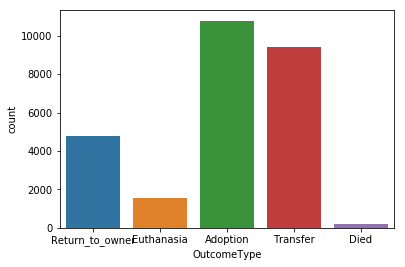

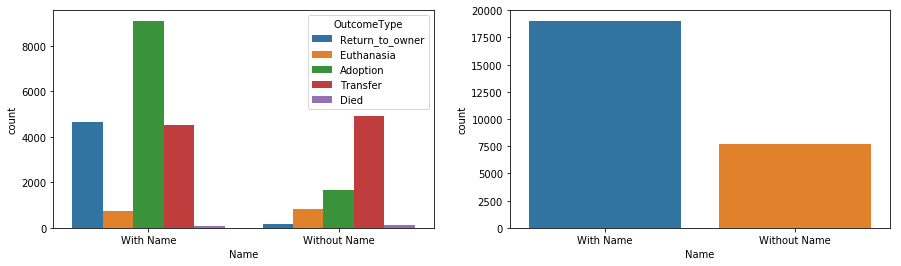

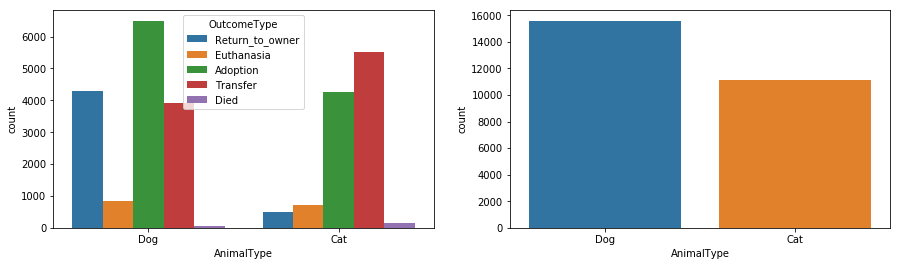

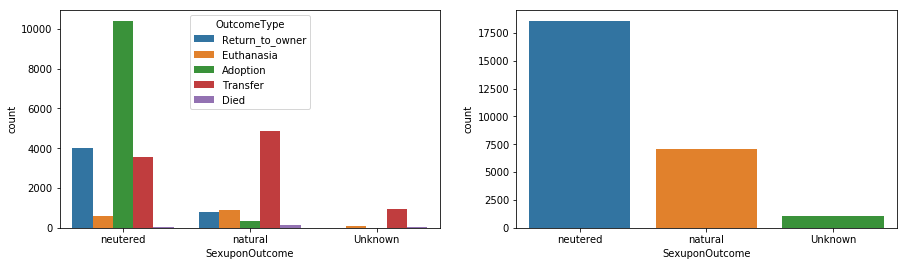

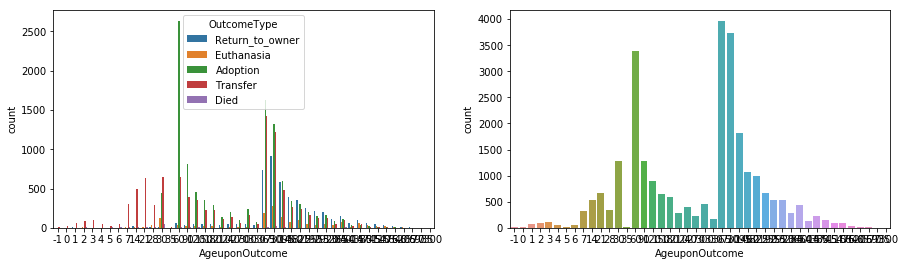

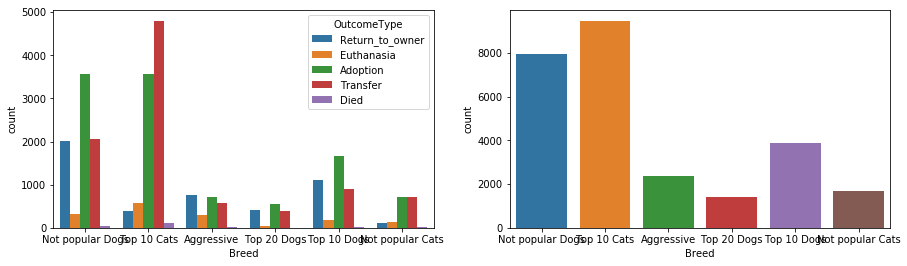

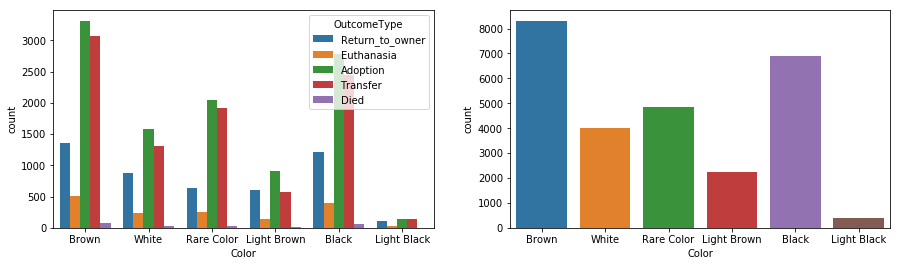

In [13]:
sns.countplot(df.OutcomeType)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.Name, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.Name, ax=ax2)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.AnimalType, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.AnimalType, ax=ax2)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.SexuponOutcome, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.SexuponOutcome, ax=ax2)
plt.show()
              
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.AgeuponOutcome, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.AgeuponOutcome, ax=ax2)
plt.show()
              
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.Breed, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.Breed, ax=ax2)
plt.show()
              
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(df.Color, hue = df.OutcomeType, ax=ax1)
sns.countplot(df.Color, ax=ax2)
plt.show()


# Encoding by LabelEncoder

In [14]:
from sklearn.preprocessing import LabelEncoder

features = ["Name", "OutcomeType", "AnimalType", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"]

for i in features:
    le = LabelEncoder()
    le.fit(df[i])
    df[i] = le.transform(df[i])

# RandomForest: Feature Importance

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
X = ["Name","AnimalType","SexuponOutcome","AgeuponOutcome","Breed"]
x = df[X]
y = df["OutcomeType"]

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(x, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 2 (0.404789)
2. feature 3 (0.319128)
3. feature 0 (0.162797)
4. feature 1 (0.087149)
5. feature 4 (0.026137)


# RandomForest: log_loss

In [16]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold

forest = ExtraTreesClassifier(n_estimators=5)

# model = LinearRegression()
cv = KFold(5, shuffle=True)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv.split(x)):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    forest.fit(x_train, y_train) 
    y_pred = forest.predict_proba(x_test)
    scores[i] = log_loss(y_test, y_pred)

scores

array([ 1.44399093,  1.49248023,  1.4493563 ,  1.41494241,  1.47021485])

# xgboost: log_loss

In [17]:
import xgboost
from sklearn.model_selection import KFold

model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

# model = LinearRegression()
cv = KFold(5, shuffle=True)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv.split(x)):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    model_xgb.fit(x_train, y_train) 
    y_pred = model_xgb.predict_proba(x_test)
    scores[i] = log_loss(y_test, y_pred)

scores

/Users/jakekong/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([ 0.8715693 ,  0.84419298,  0.85720052,  0.86267166,  0.85486555])

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

print (cross_val_score(forest, x, y, cv=KFold(5, shuffle=True), scoring = "accuracy"))
print ()
print (cross_val_score(model_xgb, x, y, cv=KFold(5, shuffle=True), scoring = "accuracy"))


[ 0.63804714  0.63935653  0.64983165  0.63898242  0.65201123]

[ 0.64309764  0.65170221  0.64796109  0.63673775  0.63536015]


In [129]:
df10= pd.read_csv("train.csv")
df10["Breed"] = df10["Breed"].replace(np.nan, "Unknown")


df10["Breed"] = df10["Breed"].apply(breed_major)

breed_list = df10["Breed"].unique() # 각 종이 나열되있음.


euthan_breed0 = df10.loc[df10['OutcomeType'] == 'Euthanasia']
adopt_breed0= df10.loc[df10['OutcomeType'] == 'Adoption']
trans_breed0= df10.loc[df10['OutcomeType'] == 'Transfer']
die_breed0= df10.loc[df10['OutcomeType'] == 'Died']
return_breed0= df10.loc[df10['OutcomeType'] == 'Return_to_owner']


euthan_breed = euthan_breed0.groupby("Breed")
adopt_breed = adopt_breed0.groupby("Breed")
trans_breed = trans_breed0.groupby("Breed")
die_breed = die_breed0.groupby("Breed")
return_breed = return_breed0.groupby("Breed")

all_breed = df10.groupby("Breed")
total = all_breed.size().sort_values(ascending = False)

euthan = euthan_breed.size().sort_values(ascending = False)
adopt = adopt_breed.size().sort_values(ascending = False)
trans = trans_breed.size().sort_values(ascending = False)
died = die_breed.size().sort_values(ascending = False)
returned = return_breed.size().sort_values(ascending = False)



for i in breed_list:
    i = str(i)
    if i in euthan:
        euthan_rate = euthan["{}".format(i)] / total["{}".format(i)]
    if i in adopt:
        adopt_rate = adopt["{}".format(i)] / total["{}".format(i)]
    if i in trans:
        trans_rate = trans["{}".format(i)] / total["{}".format(i)]
    if i in died:
        died_rate = died["{}".format(i)] / total["{}".format(i)]
    if i in returned:
        returned_rate = returned["{}".format(i)] / total["{}".format(i)]
        
    print ("{}".format(i), total[i])
    print ("euthan_rate = {}".format(euthan_rate))
    print ("trans_rate = {}".format(trans_rate))
    print ("adopt_rate = {}".format(adopt_rate))
    print ("returned_rate = {}".format(returned_rate))
    print ('died_rate ={}'.format(died_rate))
    print ()
    

Shetland Sheepdog 37
euthan_rate = 0.08108108108108109
trans_rate = 0.24324324324324326
adopt_rate = 0.2972972972972973
returned_rate = 0.3783783783783784
died_rate =0.058823529411764705

Domestic Shorthair 8958
euthan_rate = 0.06083947309667336
trans_rate = 0.5140656396517079
adopt_rate = 0.371511498102255
returned_rate = 0.04063407010493414
died_rate =0.01294931904442956

Pit Bull 2113
euthan_rate = 0.13582584003786086
trans_rate = 0.24372929484145764
adopt_rate = 0.2957879791765263
returned_rate = 0.3208707998106957
died_rate =0.003786086133459536

Lhasa Apso 70
euthan_rate = 0.014285714285714285
trans_rate = 0.6142857142857143
adopt_rate = 0.08571428571428572
returned_rate = 0.2714285714285714
died_rate =0.014285714285714285

Cairn Terrier 142
euthan_rate = 0.02112676056338028
trans_rate = 0.24647887323943662
adopt_rate = 0.5774647887323944
returned_rate = 0.15492957746478872
died_rate =0.014285714285714285

American Pit Bull Terrier 83
euthan_rate = 0.060240963855421686
trans_rate